In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import os, sys, inspect
import commands
import hep as hp

gamma = 0.577
d = 3.999
Delta = 2.0/(4.0-d)+np.log(4.0*np.pi)-gamma

In [3]:
def func(s2phi, s2ba, M1, M2, MAo, Mho, MHo, v, lam2, lam3, lam7, lam8, lam9, lam10, lamh):
    M12 = M1*M1; M22 = M2*M2; MAo2 = MAo*MAo; Mho2 = Mho*Mho; MHo2 = MHo*MHo;
    k = s2phi*np.log(M22/M12)/(4.*np.pi)**2
    phi = 0.5*np.arcsin(s2phi)
    ba = 0.5*np.arcsin(s2ba)
    lam6 = -s2ba*(MHo2-Mho2)/(2.0*v*v)
    Mu  = (M22-M12)*s2phi/(np.sqrt(2.0)*v)
    MH2 = M12*(np.sin(phi))**2+M22*(np.cos(phi))**2
    M332 = M12*(np.cos(phi))**2+M22*(np.sin(phi))**2
    lam1 = 0.5*(MHo2+Mho2-np.sqrt((MHo2-Mho2)**2-4.0*v**4*lam6**2))/(v**2)
    Mu22 = MH2-0.5*lam3*(v**2)
    Muh2 = M332-0.5*lam8*(v**2)
    lam4 = 0.5*(np.sqrt((MHo2-Mho2)**2-4.0*v**4*lam6**2)+MHo2+Mho2+2.0*(MAo2-2.0*MH2))/(v**2)
    lam5 = 0.5*(np.sqrt((MHo2-Mho2)**2-4.0*v**4*lam6**2)+MHo2+Mho2-2.0*MAo2)/(v**2)        
    return k, Mu, Muh2, Mu22, lam1, lam4, lam5, lam6, phi, ba

In [4]:
def theta_beta_alpha_range( thbamin=np.arcsin(0.96),thbamax=np.pi/2,ntab=1000,\
                          exps=[1E-5,0.8,0.999,1]):
    thba=np.concatenate((\
      ( thbamin+(thbamax - thbamin)*( np.exp( np.random.uniform( np.log( exps[2] ), np.log( exps[3]  ) ,int(ntab/2. ) ) ) ) ),\
      ( thbamin+(thbamax - thbamin)*( np.exp( np.random.uniform( np.log( exps[1] ), np.log( exps[2]  ) ,int(ntab/2. ) ) ) ) ) ) ) 
    thba=np.concatenate(( thba,\
      ( thbamin+(thbamax - thbamin)*( np.exp( np.random.uniform( np.log( exps[0]  ), np.log( exps[1] ) ,int(ntab/3.)) ) ) )        ))
    return thba

def check_theta_beta_alpha_range():
    thba=theta_beta_alpha_range()
    print np.sin( thba ).min(),np.sin( thba ).max()
    lam6abs=(MHo**2-Mho**2)*np.sin(2.*thba)/(2.*v**2)
    print lam6abs.min(),lam6abs.max()
    kk=np.sort(lam6abs)
    for n in [0,1,2,3,4,5,6,7]:
        print -n,-n-1,kk[np.logical_and(kk>10**(-n-1),kk<10**(-n)  )].shape

In [5]:
def F(m12, m22):
    Fo = 0.5*(m12+m22)-((m12*m22)/(m12-m22))*np.log(m12/m22)
    return Fo

def T(phi, ba, M1, M2, MAo, Mho, MHo, alpha_em = 1./128., v=246.0, Mz=91.1876, Mw=80.385 ):
    Sphi2 = np.sin(phi)*np.sin(phi); Cphi2 = np.cos(phi)*np.cos(phi); 
    Sba2 = np.sin(ba)*np.sin(ba); Cba2 = np.cos(ba)*np.cos(ba);
    M12 = M1*M1; M22 = M2*M2; MAo2 = MAo*MAo; Mho2 = Mho*Mho; MHo2 = MHo*MHo; Mw2 = Mw*Mw; Mz2= Mz*Mz;
    A = 1.0/(16.0*np.pi*np.pi*alpha_em*v*v)
    B = Cba2*F(M12,Mho2)+Sba2*F(M12,MHo2)+F(M12,MAo2)
    C = Cba2*F(M22,Mho2)+Sba2*F(M22,MHo2)+F(M22,MAo2)
    D = 0.5*Sphi2*Cphi2*F(M12,M22)+Cba2*F(Mho2,MAo2)+Sba2*F(MHo2,MAo2)
    E = F(Mz2,MHo2)-F(Mw2,MHo2)-F(Mz2,Mho2)+F(Mw2,Mho2)
    y = A*(Cphi2*B+Sphi2*C-D+3.0*Cba2*E)
    return y


In [6]:
def W(q2, m2):    
    w = np.sqrt(4.0*m2-q2)
    return w

def Y(q2, m1, m2):
    y = np.sqrt(((m1+m2)*(m1+m2)-q2)*((m1-m2)*(m1-m2)-q2))
    return y

def Yo(q2, m1, m2):
    y = np.sqrt(((m1+m2)*(m1+m2)-q2)*(q2-(m1-m2)*(m1-m2)))
    return y

def Z(q2, m2):
    z = np.sqrt(4.0*q2-m2)
    return z

def Zo(q2, m2):
    z = np.sqrt(m2-4.0*q2)
    return z
    
def B22(q, m1, m2):
    m12 = m1*m1; m22 = m2*m2; q2 = q*q;
    if(q==m1):
        if(q<m2/2 and q>0):
            A = (m22-q2)**3/(q2*q2)-3.0*(m22*m22-q2*q2)/q2+3.0*(m22*m22+q2*q2)/(m22-q2)
            B = 8.0/3.0+Delta-np.log(m1*m2)
            b = 1.0/12.0*(3.0*q2/2.0+9.0*m22/2.0-m22*m22/q2-m2*m22*(Zo(q2,m22))**3*np.log((m2+Zo(q2,m22))/(m2-Zo(q2,m22)))/(q2*q2)+A*np.log(m2/m1)-B*q2)
            return b
        else:
            A = (m22-q2)**3/(q2*q2)-3.0*(m22*m22-q2*q2)/q2+3.0*(m22*m22+q2*q2)/(m22-q2)
            B = 8.0/3.0+Delta-np.log(m1*m2)
            b = 1.0/12.0*(3.0*q2/2.0+9.0*m22/2.0-m22*m22/q2-m2*m22*(Z(q2,m22))**3*np.arctan2(Z(q2,m22),m2)/(q2*q2)+A*np.log(m2/m1)-B*q2)
            return b
    if(m1==m2):
        A = 8.0/3.0+Delta-2.0*np.log(m1)
        b = 1.0/12.0*(8.0*m12-2.0*(W(q2,m12))**3*np.arctan2(q,W(q2,m12))/q-A*q2)
        return b
    else:    
        if((m1-m2)*(m1-m2) > q2):
            A = -(m12-m22)*(m12-m22)/q2+5.0/2.0*(m12+m22)
            B = (Y(q2,m1,m2))**3/(2.0*q2*q2)*np.log((m12+m22-q2+Y(q2,m1,m2))/(m12+m22-q2-Y(q2,m1,m2)))
            C = (m12-m22)**3/(q2*q2)-3.0*(m12*m12-m22*m22)/q2+3.0*(m12*m12+m22*m22)/(m12-m22)
            D = 8.0/3.0+Delta-np.log(m1*m2)
            b = 1.0/12.0*(A-B+C*np.log(m1/m2)-D*q2)
            return b
        else:
            A = -(m12-m22)*(m12-m22)/q2+5.0/2.0*(m12+m22)
            B = (Yo(q2,m1,m2))**3/(2.0*q2*q2)*np.arctan2(((m12+m22-q2)*Yo(q2,m1,m2)),((m12+m22-q2)*(m12+m22-q2)-2.0*m12*m22))
            C = (m12-m22)**3/(q2*q2)-3.0*(m12*m12-m22*m22)/q2+3.0*(m12*m12+m22*m22)/(m12-m22)
            D = 8.0/3.0+Delta-np.log(m1*m2)
            b = 1.0/12.0*(A-B+C*np.log(m1/m2)-D*q2)
            return b
    
def Bo(q, m1, m2):
    m12 = m1*m1; m22 = m2*m2; q2 = q*q;
    if(q==m1):
        if(q<m2/2 and q>0):
            A = m22/q2*(m22-3.0*q2)/(m22-q2)*np.log(m2/q)
            b = 1.0+m1*Zo(q2,m22)*np.log((m2+Zo(q2,m22))/(m2-Zo(q2,m22)))/q2-A
            return b
        else:
            A = m22/q2*(m22-3.0*q2)/(m22-q2)*np.log(m2/q)
            b = 1.0-m1*Z(q2,m22)*np.arctan2(Z(q2,m22),m2)/q2-A
            return b
    if(m1==m2):
        b = 2.0-2.0*W(q2,m12)*np.arctan2(q,W(q2,m12))/q
        return b
    else:
        if((m1-m2)*(m1-m2) > q2):
            A = ((m12+m22)*q2-(m12-m22)*(m12-m22))/((m12-m22)*q2)
            B = Y(q2,m1,m2)/(2.0*q2)*np.log((m12+m22-q2+Y(q2,m1,m2))/(m12+m22-q2-Y(q2,m1,m2)))
            b = 1.0+B+A*np.log(m1/m2)
            return b
        else:
            A = ((m12+m22)*q2-(m12-m22)*(m12-m22))/((m12-m22)*q2)
            B = Yo(q2,m1,m2)/(2.0*q2)*np.arctan2(((m12+m22-q2)*Yo(q2,m1,m2)),((m12+m22-q2)*(m12+m22-q2)-2.0*m12*m22))
            b = 1.0-B+A*np.log(m1/m2)
            return b
        
def S(phi, ba, M1, M2, MAo, Mho, MHo, v=246.0, Mz=91.1876, Mw=80.385):
    Sphi2 = np.sin(phi)*np.sin(phi); Cphi2 = np.cos(phi)*np.cos(phi); 
    Sba2 = np.sin(ba)*np.sin(ba); Cba2 = np.cos(ba)*np.cos(ba); C2phi = np.cos(2.0*phi)
    M12 = M1*M1; M22 = M2*M2; MAo2 = MAo*MAo; Mho2 = Mho*Mho; MHo2 = MHo*MHo; Mw2 = Mw*Mw; Mz2= Mz*Mz;
    A = 1.0/(np.pi*Mz2)
    B = B22(Mz,Mho,MAo)+B22(Mz,Mz,MHo)-B22(Mz,Mz,Mho)#-Mz2*Bo(Mz,Mz,MHo)+Mz2*Bo(Mz,Mz,Mho)
    C = Sba2*B22(Mz,MHo,MAo)+2.0*Sphi2*Cphi2*B22(Mz,M1,M2)
    D = 0.5*Cphi2*(C2phi-3.0)*B22(Mz,M1,M1)-0.5*Sphi2*(C2phi+3.0)*B22(Mz,M2,M2)
    y = A*(C+Cba2*B+D)
    return y

def U(phi, ba, M1, M2, MAo, Mho, MHo, v=246.0, Mz=91.1876, Mw=80.385):
    Sphi2 = np.sin(phi)*np.sin(phi); Cphi2 = np.cos(phi)*np.cos(phi); 
    Sba2 = np.sin(ba)*np.sin(ba); Cba2 = np.cos(ba)*np.cos(ba); C2phi = np.cos(2.0*phi)
    M12 = M1*M1; M22 = M2*M2; MAo2 = MAo*MAo; Mho2 = Mho*Mho; MHo2 = MHo*MHo; Mw2 = Mw*Mw; Mz2= Mz*Mz;
    A = 1.0/(np.pi*Mw2)
    B = B22(Mw,M1,MAo)+Sba2*B22(Mw,M1,MHo)+Cba2*B22(Mw,Mho,M1)
    C = B22(Mw,M2,MAo)+Sba2*B22(Mw,M2,MHo)+Cba2*B22(Mw,Mho,M2)
    D = B22(Mw,Mw,MHo)-B22(Mw,Mw,Mho)-Mw2*Bo(Mw,Mw,MHo)+Mw2*Bo(Mw,Mw,Mho)
    E = Cphi2*B22(Mw,M1,M1)+Sphi2*B22(Mw,M2,M2)
    s = S(phi, ba, M1, M2, MAo, Mho, MHo, v, Mz, Mw)
    y = A*(Cphi2*B+Sphi2*C+Cba2*D-2.0*E)-s
    return y


In [7]:
v = 246.0
s2phi = 0.0
s2ba = 0.0
M1 = 700.0
M2 = 1000.0
MAo = 705.0
Mho = 125.0
MHo = 902.0
lamh = 0.000000E+00     # lambdahInput
lam2 = 1.3000000E-01    # lambda2Input
lam3 = 1.0000000E-03    # lambda3Input
lam6 = 0.000000E-03     # lambda6Inputd 
lam7 = 0.000000E+00     # lambda7Input
lam8 = 0.0000000E-01    # lambda8Input
lam9 = 0.000000E+00     # lambda9Input
lam10 = 0.000000E+00    # lambda10Input
lamh = 0.000000E+00     # lambdahInput
                
k, Mu, Muh2, Mu22, lam1, lam4, lam5, lam6, phi, ba = func(s2phi, s2ba, M1, M2, MAo, Mho, MHo, v, lam2, lam3, lam7, lam8, lam9, lam10, lamh)

t = T(phi, 90.0*np.pi/180.0, M1, M2, MAo, Mho, MHo, alpha_em = 1./128., v=246.0, Mz=91.1876, Mw=80.385 )
s = S(phi, 90.0*np.pi/180.0, M1, M2, MAo, Mho, MHo, v=246.0, Mz=91.1876, Mw=80.385)
u = U(phi, 90.0*np.pi/180.0, M1, M2, MAo, Mho, MHo, v=246.0, Mz=91.1876, Mw=80.385)

print 'T = ',t
print 'S = ',s
print 'U = ',u

T =  0.0179202218408
S =  0.00756566870471
U =  3.54665545141e-05


In [8]:
lam=np.zeros(11)
df=pd.DataFrame()
s2phi = 1.4E-02
s2ba = 0.0045927703511266082
lam2min=1E-3
lam3min=1E-3
lam6min=1E-3
lam8min=1E-3
lammax=np.sqrt(4.*np.pi)

npoints=50000

M1min=70.; Mscmax=2000.;MAomin=30.
s2phimin=1E-4; s2phimax=0.5
m1min=1E-27;m1max=1E-11

for i in range(npoints):
    sc=pd.Series()
    sc['M1'] = np.exp( np.random.uniform(np.log(M1min),np.log(Mscmax)  ) )
    sc['M2'] = np.exp( np.random.uniform(np.log(sc.M1+sc.M1*0.1),np.log(Mscmax)  ) )
    sc['Mho'] = 125.0
    sc['MAo'] = np.exp( np.random.uniform(np.log(MAomin),np.log(Mscmax)  ) )
    sc['MHo'] = np.exp( np.random.uniform(np.log(sc.Mho+sc.Mho*0.1),np.log(Mscmax)  ) )
    if np.abs(sc.MHo-sc.M1)>400 and np.abs(sc.MAo-sc.MHo)>400:
        sc['MHo']=sc.M1+np.random.choice([1,-1])*np.random.uniform(0,100)
    if np.abs(sc.MAo-sc.M1)>400 and np.abs(sc.MAo-sc.MHo)>400:
        sc['MAo']=sc.M1+np.random.choice([1,-1])*np.random.uniform(0,100)            
    sc['s2phi']=s2phi
    sc['v']=v
    ba=np.random.choice(theta_beta_alpha_range())
    sc['s2ba'] = np.sin(2.*ba)
    lam[2] = np.exp(np.random.uniform(np.log(lam2min),np.log(lammax)  ) )
    lam[3] = np.exp(np.random.uniform(np.log(lam3min),np.log(lammax)  ) )
    lam[7] = 0. 
    lam[8] = np.exp(np.random.uniform(np.log(lam8min),np.log(lammax)  ) )
    lam[9] = 0. 
    lam[10] = 0.
    sc['lamh']=0
    sc['k'],sc['Mu'],sc['Muh2'],sc['Mu22'],lam[1],lam[4],lam[5],lam[6],phi,ba =\
                                func(sc.s2phi,sc.s2ba,sc.M1,sc.M2,sc.MAo,sc.Mho,sc.MHo,sc.v,\
                                        lam[2],lam[3],lam[7],lam[8],lam[9],lam[10],sc.lamh)
    
    sc['T'] = T(phi, ba, sc['M1'], sc['M2'], sc['MAo'], sc['Mho'], sc['MHo'], alpha_em = 1./128., v=246.0, Mz=91.1876, Mw=80.385 )
    sc['S'] = S(phi, ba, sc['M1'], sc['M2'], sc['MAo'], sc['Mho'], sc['MHo'], v=246.0, Mz=91.1876, Mw=80.385)
    sc['U'] = U(phi, ba, sc['M1'], sc['M2'], sc['MAo'], sc['Mho'], sc['MHo'], v=246.0, Mz=91.1876, Mw=80.385)
    if(sc['S']<0.16 and sc['S']>-0.06 and sc['T']<0.22 and sc['T']>-0.04 and sc['U']<0.12 and sc['U']>-0.1):
        df=df.append(sc,ignore_index=True)
    
df.shape

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid

(3480, 16)

In [9]:
df

,M1,M2,MAo,MHo,Mho,Mu,Mu22,Muh2,S,T,U,k,lamh,s2ba,s2phi,v
0,126.560378,292.191494,494.088873,132.281049,125.0,2.791108,8.528717e+04,15606.918935,0.056236,-0.012219,0.012023,0.000148,0.0,0.000292,0.014,246.0
1,119.321469,201.033848,71.449972,125.288108,125.0,1.053411,2.822391e+04,13056.909059,-0.009808,-0.004883,-0.000055,0.000092,0.0,0.073650,0.014,246.0
2,100.635859,495.246110,59.587256,99.315476,125.0,9.462514,2.433849e+05,-10541.751816,-0.010645,-0.002459,0.029431,0.000283,0.0,0.112932,0.014,246.0
3,153.529751,199.089035,176.007567,140.918344,125.0,0.646488,3.943030e+04,9960.650675,0.003629,-0.018876,0.036965,0.000046,0.0,0.533857,0.014,246.0
4,95.748522,165.414093,136.634679,185.147887,125.0,0.732162,2.537262e+04,8704.570528,0.031468,-0.010120,-0.032563,0.000097,0.0,0.015510,0.014,246.0
5,101.408591,790.521304,195.668246,145.384435,125.0,24.734260,6.228020e+05,9406.190255,0.032073,0.027711,0.063610,0.000364,0.0,0.073659,0.014,246.0
6,152.023294,690.003211,33.389002,134.187550,125.0,18.229290,4.760228e+05,19321.308409,-0.029191,0.046695,0.023459,0.000268,0.0,0.000034,0.014,246.0
7,121.759198,607.084425,113.687942,92.789151,125.0,14.234596,3.684522e+05,11320.630049,-0.010883,0.017965,0.057912,0.000285,0.0,0.000221,0.014,246.0
8,114.172937,494.688506,394.162436,153.200312,125.0,9.323282,2.258520e+05,514.750806,0.056436,0.040637,0.100612,0.000260,0.0,0.513999,0.014,246.0
9,164.397241,326.533466,108.032344,149.906896,125.0,3.203157,1.062776e+05,26913.297843,-0.012334,0.025011,0.081546,0.000122,0.0,0.537565,0.014,246.0


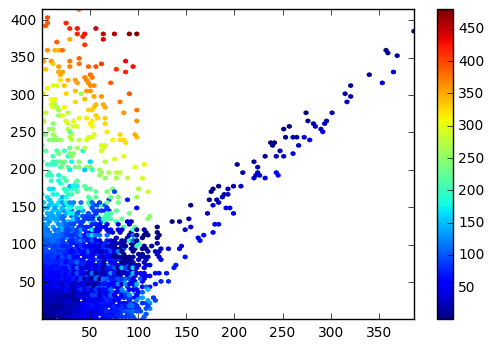

In [10]:
plt.hexbin(np.abs(df.M1-df.MHo),np.abs(df.MAo-df.MHo),np.abs(df.MAo-df.M1))
plt.colorbar()

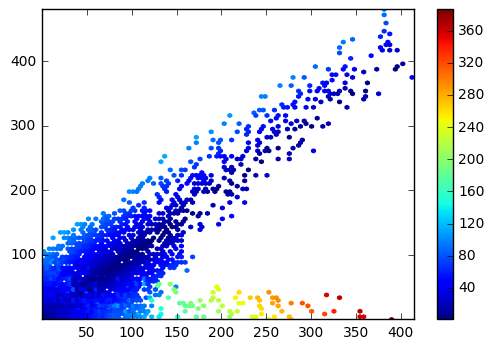

In [11]:
plt.hexbin(np.abs(df.MAo-df.MHo),np.abs(df.MAo-df.M1),np.abs(df.MHo-df.M1))
plt.colorbar()

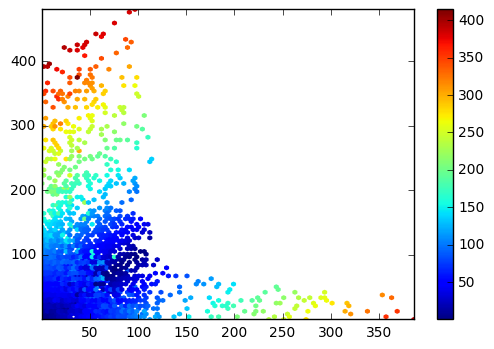

In [12]:
plt.hexbin(np.abs(df.M1-df.MHo),np.abs(df.M1-df.MAo),np.abs(df.MAo-df.MHo))
plt.colorbar()

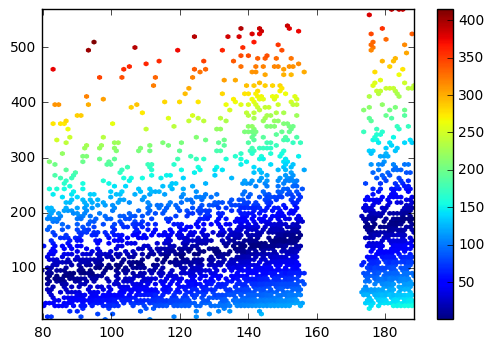

In [13]:
plt.hexbin(df.MHo,df.MAo,np.abs(df.MHo-df.MAo))
plt.colorbar()

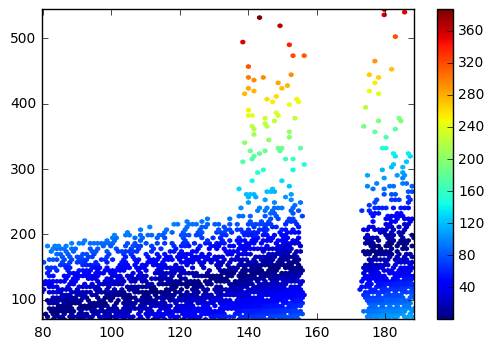

In [14]:
plt.hexbin(df.MHo,df.M1,np.abs(df.MHo-df.M1))
plt.colorbar()